## Описание проекта

Для интернет-магазина следует разработать модель, которая предсказывает снижение покупательской активности. Поскольку привлечение новых клиентов не эффективно, следует разработать персональные предложения для постоянников. Для этого будет необходимо сегментировать данные по группам:
- коммуникация с клиентом
- продуктовое поведение
- поведение на сайте
- финанасовое поведение

и провести анализ сегмента финансового поведения.

В качестве исходных данных даны 4 датасета:
- market_file. Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
- market_money. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- market_time. Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- money. Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца

## Загрузка данных

In [162]:
!pip install -U scikit-learn

In [163]:
!pip install shap -q

In [164]:
!pip install phik

In [165]:

import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import phik

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, recall_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import shap

Загрузим датафреймы и присвоим им имена для удобства дальнейшей работы.

In [166]:
warnings.filterwarnings('ignore')
market = pd.read_csv('D:\second-project\market_file.csv', sep=',')
market.name = 'market'
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [167]:
market_money = pd.read_csv('D:\second-project\market_money.csv', sep=',')
market_money.name = 'market_money'
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [168]:
market_time = pd.read_csv('D:\second-project\market_time.csv', sep=',')
market_time.name = 'market_time'
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [169]:
money = pd.read_csv('D:\second-project\money.csv', sep=';', decimal=',')
money.name = 'money'
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


#### Вывод
Содержание датафреймов соответствует описанию заказчика. При предварительном просмотре данных были найдены орфографические ошибки, следовательно стоит проверить неявные дубликаты для всех не числовых столбцов. 

## Предобработка данных

#### Изменение типов данных 

In [170]:
lst = [market, market_money, market_time, money]
for l in lst:
    print(l.name)
    print(l.dtypes)
    print()

market
id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
dtype: object

market_money
id           int64
Период      object
Выручка    float64
dtype: object

market_time
id         int64
Период    object
минут      int64
dtype: object

money
id           int64
Прибыль    float64
dtype: object



Типы данных выставлены корректно. Столбец 'Маркет_актив_6_мес' в датафрейме market содержит среднемесячное значение, поэтому он имеет дробный тип. 

#### Поиск дубликатов

In [171]:
def dup(data):
    print(data.name)
    print('количество явных дубликатов:',data.duplicated().sum())
    data.drop_duplicates(inplace=True)
    for u in data.select_dtypes('object').columns:
        print('список уникальных значений: ',u,data[u].unique())
    print()

In [172]:
for l in lst:
    dup(l)

market
количество явных дубликатов: 0
список уникальных значений:  Покупательская активность ['Снизилась' 'Прежний уровень']
список уникальных значений:  Тип сервиса ['премиум' 'стандартт' 'стандарт']
список уникальных значений:  Разрешить сообщать ['да' 'нет']
список уникальных значений:  Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

market_money
количество явных дубликатов: 0
список уникальных значений:  Период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

market_time
количество явных дубликатов: 0
список уникальных значений:  Период ['текущий_месяц' 'предыдцщий_месяц']

money
количество явных дубликатов: 0



Следует избавиться от явных дубликатов и орфографических ошибок, которые могут привести к неправильному анализу данных.

In [173]:
market['Тип сервиса'] = market['Тип сервиса'] \
                        .replace(['стандартт'],'стандарт')
market_time['Период'] = market_time['Период'] \
                        .replace(['предыдцщий_месяц'],'предыдущий_месяц')

print(market['Тип сервиса'].unique())
print(market_time['Период'].unique()) 

['премиум' 'стандарт']
['текущий_месяц' 'предыдущий_месяц']


Явных дубликатов нет, неявные исправлены

#### Поиск пропусков

In [174]:
for l in lst:
    print(l.name)
    print(l.isna().sum())

market
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
market_money
id         0
Период     0
Выручка    0
dtype: int64
market_time
id        0
Период    0
минут     0
dtype: int64
money
id         0
Прибыль    0
dtype: int64


#### Изменение индексов

После проверки явных дубликатов столбец id можно превратить в индексы.

In [175]:
for l in lst:
    l = l.set_index('id')
    display(l.head())

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6


,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдущий_месяц,13
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13


,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


#### Вывод
В предоставленных данных нет пропусков, типы данных не требуют изменения. Явные дубликаты не обнаружены. В неявных были исправлены столбцы 'Тип сервиса' в датафрейме market и 'Период' в market_time. Поиск аномалий и их исправление в числовых столбцах будет происходить в шаге исследовательский анализ данных.

Создадим функции для построения графиков.

In [176]:
def pl(data,col):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=data,x=col, hue='Покупательская активность')
    plt.subplot(1, 2, 2)
    plt.boxplot(data[col]);

In [177]:
for l in lst:
    print(l.name)
    display(l.describe())
    print()

market


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000



market_money


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000



market_time


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000



money


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Построим графики для датафрейма market

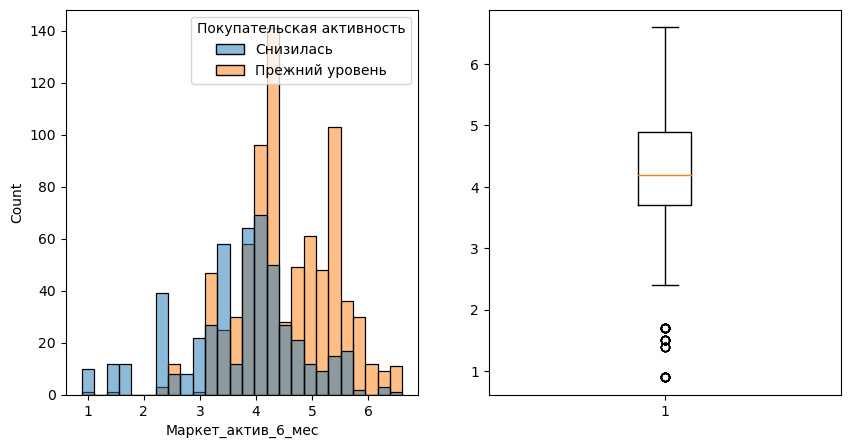

In [178]:
pl(market,'Маркет_актив_6_мес')

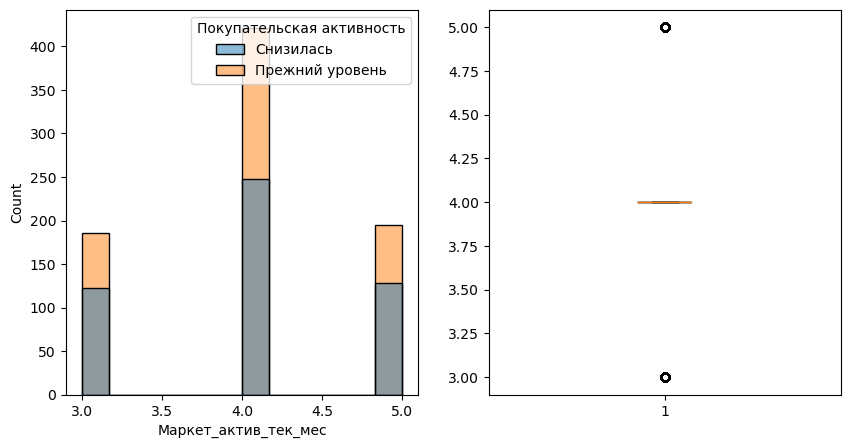

In [179]:
pl(market, 'Маркет_актив_тек_мес')

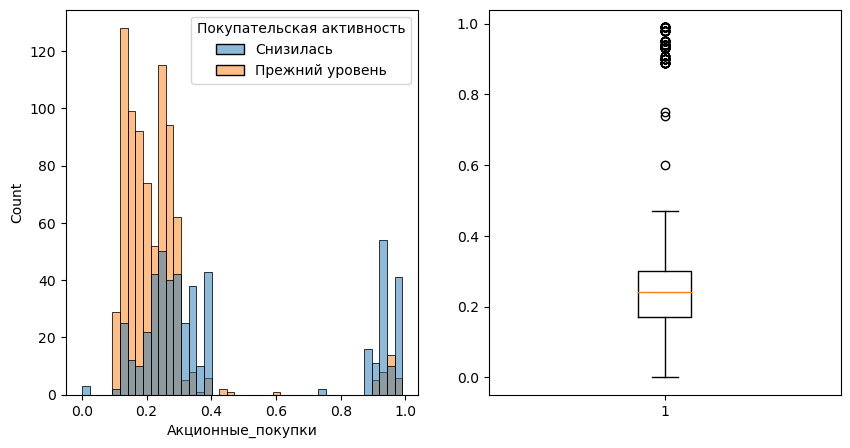

In [180]:
pl(market, 'Акционные_покупки')

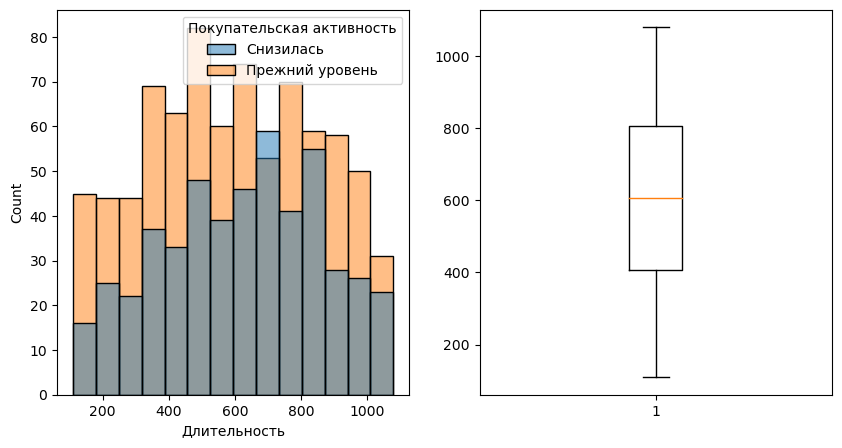

In [181]:
pl(market, 'Длительность')

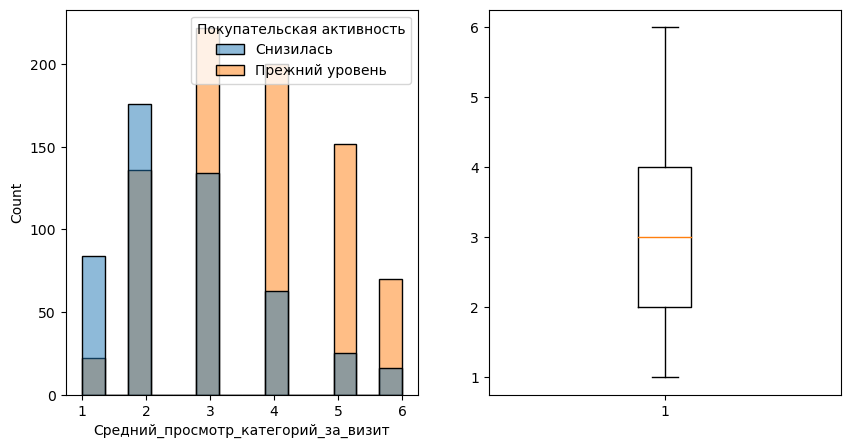

In [182]:
pl(market, 'Средний_просмотр_категорий_за_визит')

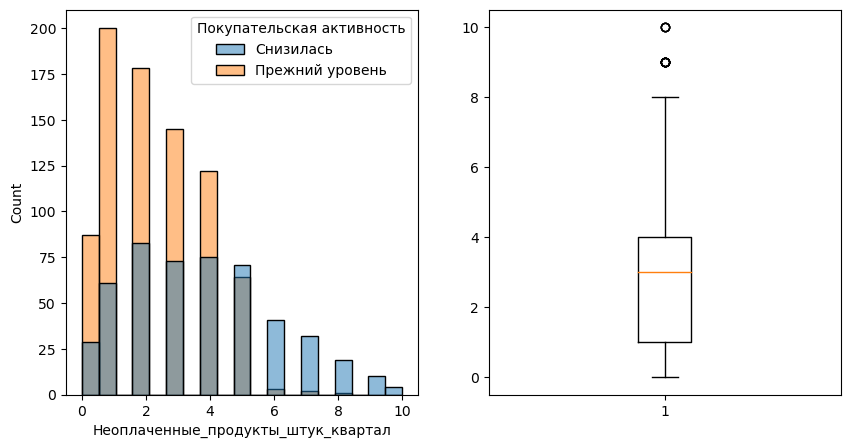

In [183]:
pl(market, 'Неоплаченные_продукты_штук_квартал')

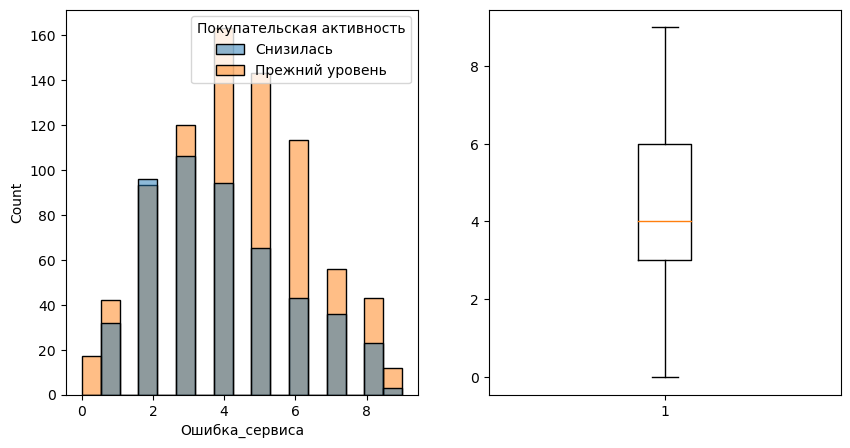

In [184]:
pl(market, 'Ошибка_сервиса')

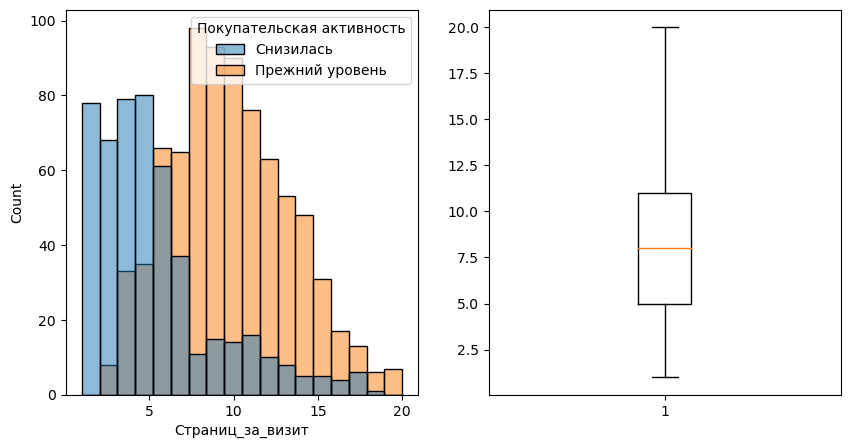

In [185]:
pl(market, 'Страниц_за_визит')

Построим графики для датафрейма market_money

Перед построением найдем аномальное значение, увиденное ранее при вызове функции describe

Axes(0.125,0.11;0.775x0.77)


,id,Период,Выручка
98,215380,текущий_месяц,106862.2


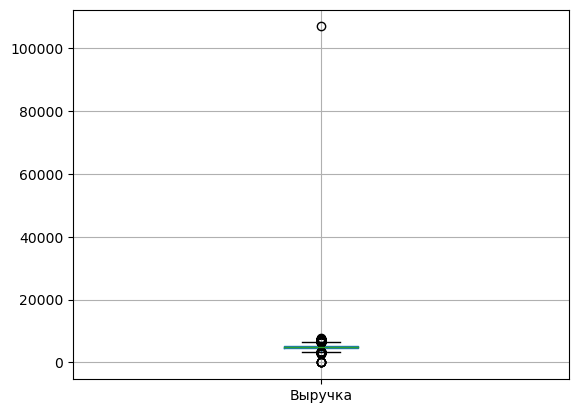

In [186]:
print(market_money.boxplot('Выручка'))
market_money[market_money['Выручка'] > 100000]

Так как нет возможности уточнить является ли такое значение реальным или нет, то стоит его удалить, потому-что оно будет сильно лиять на модель. В дальнейшем покупательскую активность этого покупателя нужно будет отслеживать вручную.

In [187]:
market = market.query('id != 215380')
market_money = market_money.query('id != 215380')
market_time = market_time.query('id != 215380')
money = money.query('id != 215380')

print(market.shape)
print(market_money.shape)
print(market_time.shape)
print(money.shape)

(1299, 13)
(3897, 3)
(2598, 3)
(1299, 2)


id удален корректно

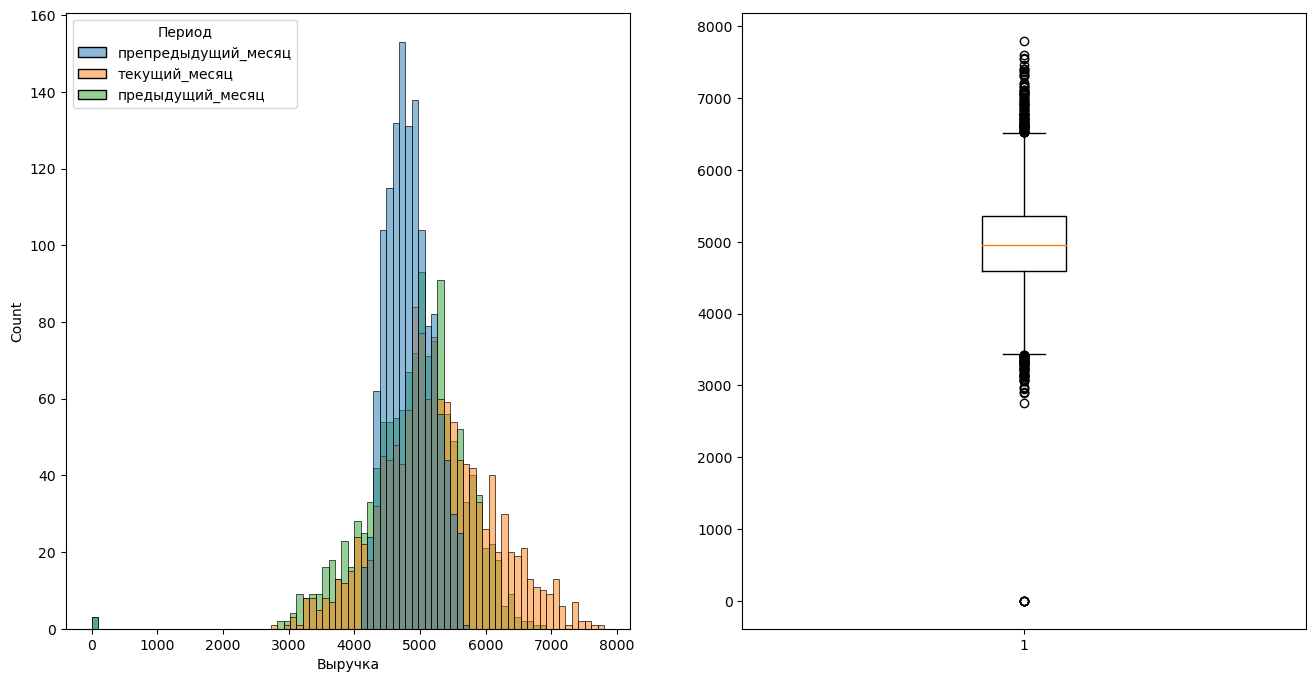

In [188]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.histplot(data=market_money, x='Выручка',hue='Период')
plt.subplot(1, 2, 2)
plt.boxplot(market_money['Выручка']);

Построим графики для датафрейма market_time

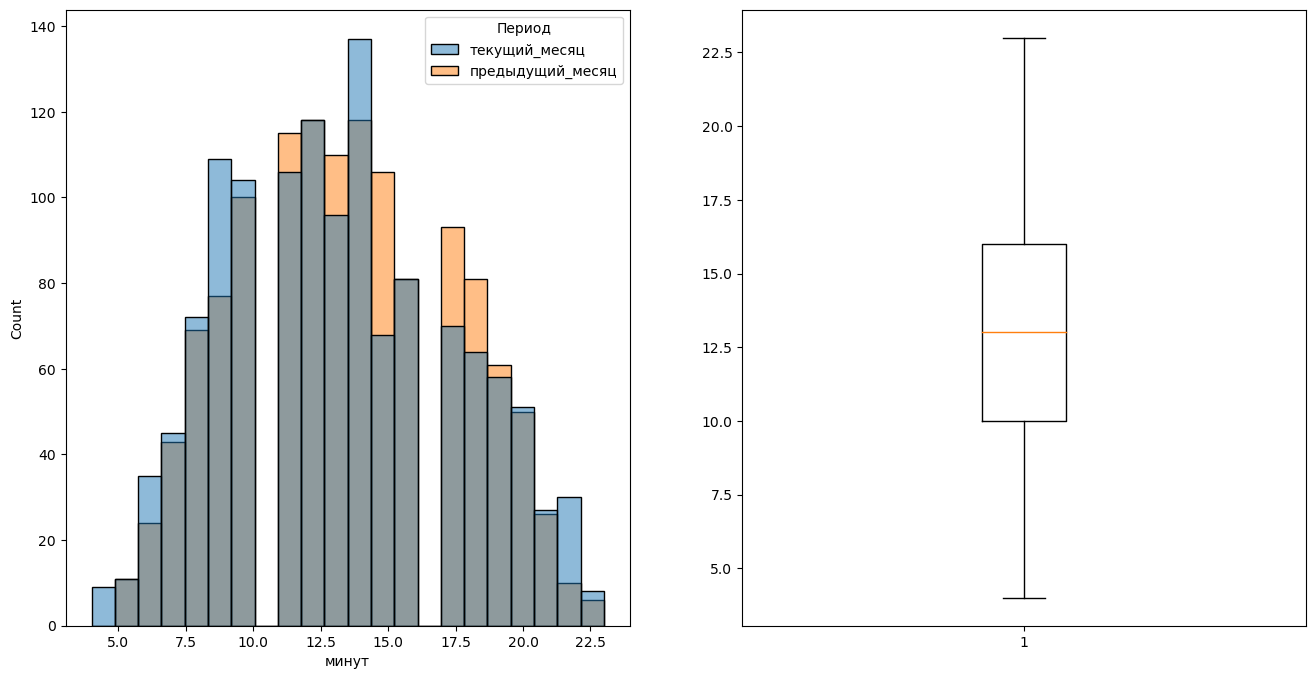

In [189]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.histplot(data=market_time, x='минут',hue='Период');
plt.subplot(1, 2, 2)
plt.boxplot(market_time['минут']);

Построим графики для датафрейма money

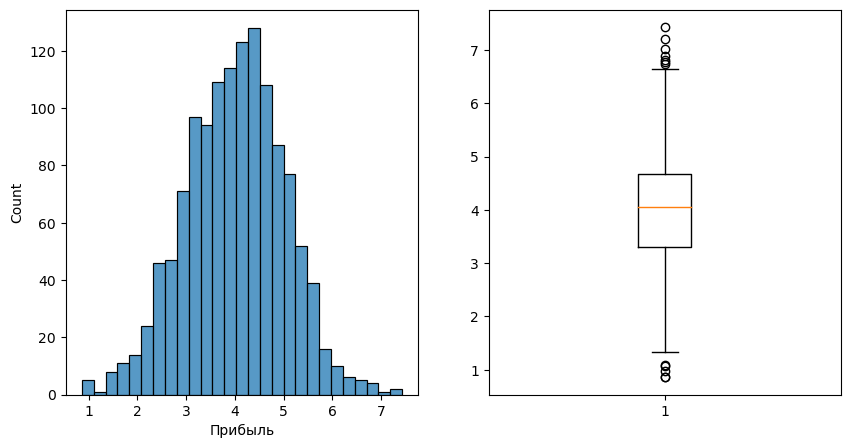

In [190]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(money['Прибыль'])
plt.subplot(1, 2, 2)
plt.boxplot(money['Прибыль']);

#### Вывод

Распределение данных по целевому признаку показало, что покупателей со сниженной активностью меньше, чем покупателей с прежней. Уменьшение просмотра категорий и страниц за визит является сигналом к снижению покупательской активности. Удаление выбросов найденных на боксплотах не имеет смысла, так как они отражают нулевые значения(Маркет_актив_6_мес) или являются особенностями распределения(признак Акционные_покупки). Значение выручки за текущий период имеют меньший разброс, чем за прошлые периоды.

В этом шаге были определены особенности дальнейшей работы с данными:
- Использование корреляции Спирмана
- Категоризация столбца Акционные покупки

## Объединение таблиц

В первую очередь изменим датафреймы так, чтобы значения периода стали столбцами. Заранее перименуем столбцы

In [191]:
mm = pd.pivot_table(market_money, index='id',columns='Период',values='Выручка')
mm = mm.rename(columns = {'предыдущий_месяц':'пред_месяц_выручка',
                          'препредыдущий_месяц':'препред_месяц_выручка',
                          'текущий_месяц':'тек_месяц_выручка'})

mt = pd.pivot_table(market_time, index='id',columns='Период',values='минут')
mt = mt.rename(columns = {'предыдущий_месяц':'пред_месяц_минут','текущий_месяц':'тек_месяц_минут'})

market_money_time = pd.merge(mm, mt, how='left', on=['id'])

market_money_time['пред_месяц_выручка'] = market_money_time['пред_месяц_выручка'] \
.replace(0,market_money_time['пред_месяц_выручка'].mean())

display(market_money_time.head())
market_money_time.shape

Период,пред_месяц_выручка,препред_месяц_выручка,тек_месяц_выручка,пред_месяц_минут,тек_месяц_минут
id,,,,,
215348,4936.042725,0.0,3293.1,13,14
215349,5216.000000,4472.0,4971.6,12,10
215350,5457.500000,4826.0,5058.4,8,13
215351,6158.000000,4793.0,6610.4,11,13
215352,5807.500000,4594.0,5872.5,8,11


(1299, 5)

In [192]:
market_money_time = market_money_time.query('(пред_месяц_выручка != 0) \
                                            &(препред_месяц_выручка != 0) \
                                            &(тек_месяц_выручка != 0)')
display(market_money_time.head())
market_money_time.shape

Период,пред_месяц_выручка,препред_месяц_выручка,тек_месяц_выручка,пред_месяц_минут,тек_месяц_минут
id,,,,,
215349,5216.0,4472.0,4971.6,12,10
215350,5457.5,4826.0,5058.4,8,13
215351,6158.0,4793.0,6610.4,11,13
215352,5807.5,4594.0,5872.5,8,11
215353,4738.5,5124.0,5388.5,10,10


(1296, 5)

Объединим датафреймы

In [193]:
market_full = pd.merge(market, market_money_time, how='inner', on=['id'])
market_full = market_full.set_index('id')
display(market_full.head())
print('Должно получиться столбцов:',market.shape[1] + market_money_time.shape[1])
market_full.shape

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,пред_месяц_выручка,препред_месяц_выручка,тек_месяц_выручка,пред_месяц_минут,тек_месяц_минут
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Должно получиться столбцов: 18


(1296, 17)

#### Вывод

Количество строк и столбцов совпадает, следовательно объединение датафреймов успешно.

## Корреляционный анализ

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(market_full.corr(method='spearman'),annot=True, fmt='.2f', cmap='coolwarm');

У некоторых признаков есть сильная взаимосвязь, однако мультиколлинеарность отсутствует. У меркетинговой активности есть связь с количеством времени, которое покупатели проводят на сайте, но связь с выручкой меньше. Это может означать, что акционные предложения могут заинтересовать людей, но не сколоняют их к покупке.

Построим матрицу корреляции, с учетом категориальных признаков, для анализа снижения покупательской активности

In [ ]:
phik_overview_dec = market_full[market_full['Покупательская активность']=='Снизилась'].phik_matrix();
plot_correlation_matrix(phik_overview_dec.values, x_labels=phik_overview_dec.columns, y_labels=phik_overview_dec.index,
                        figsize=(15,12)
                       );
plt.tight_layout();

Теперь изучим корреляцию для прежнего уровня покупательской активности.

In [ ]:
phik_overview_save = market_full[market_full['Покупательская активность']=='Прежний уровень'].phik_matrix()
plot_correlation_matrix(phik_overview_save.values, x_labels=phik_overview_save.columns, y_labels=phik_overview_save.index,
                        figsize=(15,12)
                       )
plt.tight_layout()

In [ ]:
sns.pairplot(market_full)

Квадратичная зависимость отсутсвует. Сильная прямая зависмость у признаков пред_месяц_выручка и тек_месяц_выручка.

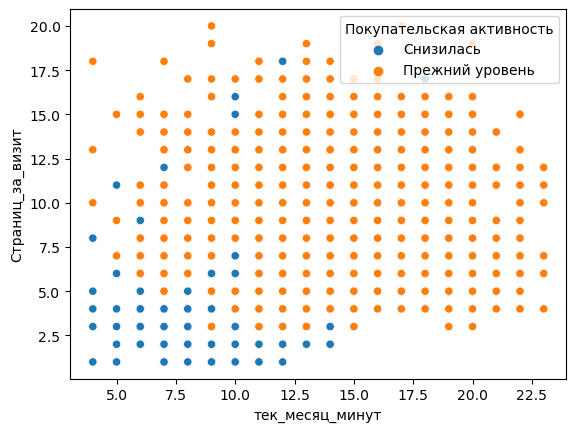

In [194]:
sns.scatterplot(data=market_full, x='тек_месяц_минут', y='Страниц_за_визит',hue='Покупательская активность');

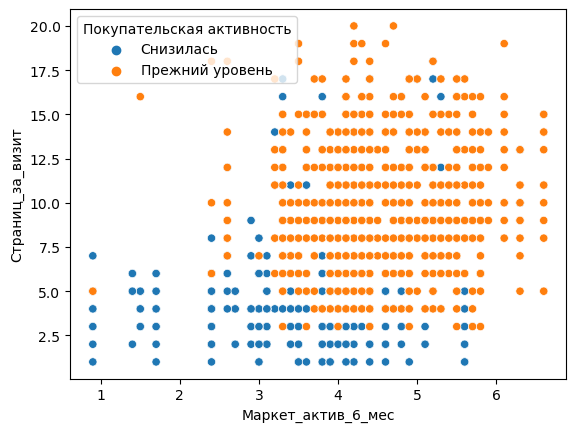

In [195]:
sns.scatterplot(data=market_full, x='Маркет_актив_6_мес', y='Страниц_за_визит',hue='Покупательская активность');

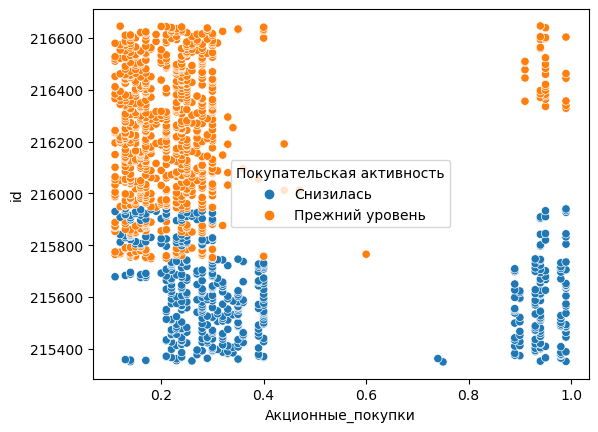

In [196]:
sns.scatterplot(data=market_full, x='Акционные_покупки', y='id',hue='Покупательская активность');

#### Вывод 
Помимо наличия сильной зависимости между некоторыми признаками, видна граница классификации для целевого признака.

У матрицы корреляции, описывающей снижение покупательской активности, более сильные зависимости между признаками, чем у матрицы прежнего уровня. Количество выручки напрямую связано признаками описывающими время потраченное на сайте и маркетинговую активность.

Диаграмма рассеяния для id и акционных покупок имеет странное распределение, это может быть свзяано с тем, что старые покупатели(id меньших значений) утрачивают интерес к покупкам на сайте, либо для новых пользователей существуют предложения стимулирующие к покупке.

## Использование пайплайнов

В данном шаге требуется создать пайплайны для подготовки данных(два кодировщика и два скайлера), обучения четырех моделей, и подбора гиперпаремтров к ним.  

Так как нельзя пропускать снижение активности покупателей, закодируем ее 1 и выберем метрику recall.

Перед созданием пайплайнов разобъем датасет на выборки и сделаем списки с названиями признаков. 

In [197]:
X = market_full.drop(columns = ['Покупательская активность'])
y = market_full['Покупательская активность']


X['Акционные_покупки'] = pd.DataFrame(np.where(X['Акционные_покупки'] > 0.65, 1, 0), 
                  index=X['Акционные_покупки'].index, 
                            )
y = pd.DataFrame(np.where(y == 'Снизилась', 1, 0), 
                  index=y.index, 
                            )

RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE ,
    random_state = RANDOM_STATE,
    stratify = y
)



ohe_columns = ['Разрешить сообщать', 'Акционные_покупки','Популярная_категория']

ord_columns = ['Тип сервиса']

num_columns  = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

Создадим пайплайн для подготовки данных.

In [198]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['стандарт', 'премиум']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Финальный пайплайн:

In [199]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'))
])

Найдем лучшую модель и ее параметры. Так как количество моделей и параметров большое, выберем случайный поиск, как наиболее быстрый метод.

In [200]:
param_rs = [
     {
     'models': [DecisionTreeClassifier(random_state=42)],
     'models__min_samples_leaf': range(7, 8),
     'models__min_samples_split': range(10, 12),
     'models__max_depth': range(7, 9) 
     }
]

rs = RandomizedSearchCV (
    pipe_final,
    param_rs,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state = RANDOM_STATE
)

rs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs.best_params_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', rs.best_score_)

Лучшая модель и её параметры:

 {'models__min_samples_split': 10, 'models__min_samples_leaf': 7, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}
Метрика лучшей модели на кросс-валидационной выборке: 0.7358918918918919


In [201]:
y_test_proba = rs.predict_proba(X_test)
y_test_pred = rs.predict(X_test)

print('Значение метрики roc_auc на тестовой выборке:',recall_score(y_test, y_test_pred))
print('Изменение метрики:',recall_score(y_test, y_test_pred) - rs.best_score_)

Значение метрики roc_auc на тестовой выборке: 0.7723577235772358
Изменение метрики: 0.0364658316853439


#### Вывод

В столбеце Акционные покупки заметно разделение данных на две части, поэтому данные разделены по границе(0.65).

Лучшие результаты показала модель логистической регрессии с лассо-регуляризацией. Показания выбранной метрики: 0,74. Значения на тестовой метрике: 0,77

## Анализ важности признаков

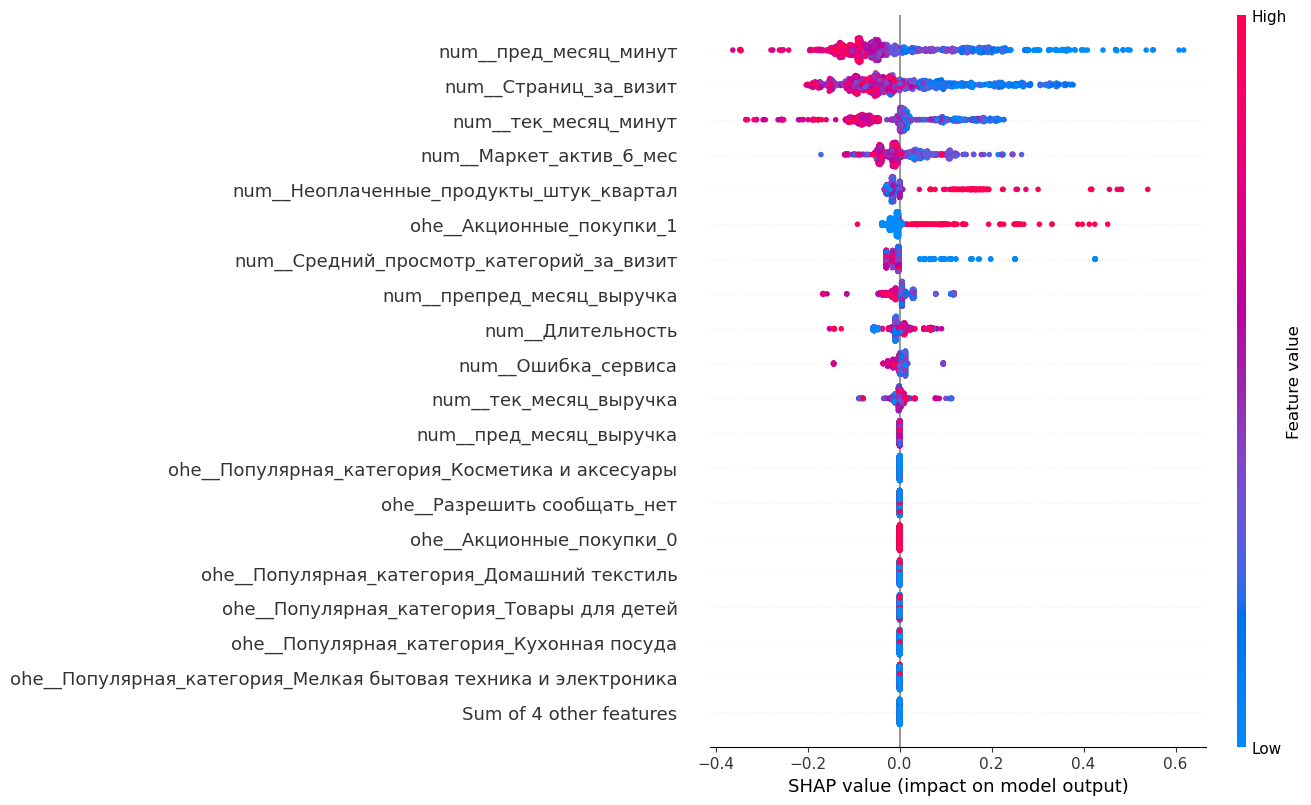

In [202]:
best_model = rs.best_estimator_
best_model['preprocessor'].transform(X_train)
best_model['preprocessor'].get_feature_names_out()
data = pd.DataFrame(best_model['preprocessor'].transform(X_train),\
                      columns=best_model['preprocessor'].get_feature_names_out())


explainer = shap.TreeExplainer(best_model['models'], data = data)

shap_values = explainer.shap_values(data)
shap_obj = explainer(data)

shap.plots.beeswarm(shap_obj[:,:,1], max_display=20)

#### Вывод

Из графиков видно, что наибольший вес имеют признаки связанные с количеством времени проведенного на сайте и долгосрочная маркетинговая активность. Увеличение этих показателей способствует сохранению покупательской активности. Увеличение количества неоплаченных или акционных покупок, наоборот, ведет к снижению активности.

Категории косметика и аксессуары и техника для красоты и здоровья имеют низкую популярность.

## Сегментация покупателей

Соберем данные по полученной диаграмме Исикавы, без учета признаков с низким весом. Для начала работы добавим прибыльность и предсказанные значения к остальным

In [203]:
df_pred = X_test
df_pred = df_pred.merge(money, on = 'id', how='left') 
df_pred['Покупательская_активность'] = y_test_pred
df_pred = df_pred.set_index('id')

print(df_pred.shape)
df_pred.head()

(324, 18)


,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,пред_месяц_выручка,препред_месяц_выручка,тек_месяц_выручка,пред_месяц_минут,тек_месяц_минут,Прибыль,Покупательская_активность
id,,,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,4.69,0
215654,премиум,нет,1.4,4,684,1,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,2.75,1
216307,премиум,да,3.3,4,488,0,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,3.16,0
215501,премиум,да,3.5,3,1057,0,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,3.74,1
215934,стандарт,нет,5.5,4,147,1,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,4.40,1


#### Коммуникация с клиентом

In [204]:
df_comm = df_pred[['Тип сервиса','Маркет_актив_6_мес',
                   'Маркет_актив_тек_мес',
                   'Длительность', 'Акционные_покупки','Покупательская_активность','Прибыль']]
print('Количество клиентов в сегменте коммуникации:', df_comm.shape[0])
display(df_comm.head())

Количество клиентов в сегменте коммуникации: 324


,Тип сервиса,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Покупательская_активность,Прибыль
id,,,,,,,
216161,стандарт,4.1,4,606,0,0,4.69
215654,премиум,1.4,4,684,1,1,2.75
216307,премиум,3.3,4,488,0,0,3.16
215501,премиум,3.5,3,1057,0,1,3.74
215934,стандарт,5.5,4,147,1,1,4.40


#### Продуктовое поведение

In [205]:
df_prod = df_pred[['Популярная_категория',
                   'Неоплаченные_продукты_штук_квартал',
                   'Средний_просмотр_категорий_за_визит','Покупательская_активность','Прибыль']]
print('Количество клиентов в сегменте продуктового поведения:', df_prod.shape[0])
display(df_prod.head())

Количество клиентов в сегменте продуктового поведения: 324


,Популярная_категория,Неоплаченные_продукты_штук_квартал,Средний_просмотр_категорий_за_визит,Покупательская_активность,Прибыль
id,,,,,
216161,Техника для красоты и здоровья,1,6,0,4.69
215654,Товары для детей,6,3,1,2.75
216307,Домашний текстиль,2,4,0,3.16
215501,Домашний текстиль,3,4,1,3.74
215934,Мелкая бытовая техника и электроника,2,1,1,4.40


#### Поведение на сайте

In [206]:
df_web = df_pred[['Страниц_за_визит','пред_месяц_минут','тек_месяц_минут','Покупательская_активность','Прибыль']]
print('Количество клиентов в сегменте поведения на сайте:', df_web.shape[0])
display(df_web.head())

Количество клиентов в сегменте поведения на сайте: 324


,Страниц_за_визит,пред_месяц_минут,тек_месяц_минут,Покупательская_активность,Прибыль
id,,,,,
216161,12,16,17,0,4.69
215654,6,11,9,1,2.75
216307,10,20,11,0,3.16
215501,6,9,9,1,3.74
215934,7,15,18,1,4.40


#### Финансовое поведение

In [207]:
df_fin = df_pred[['тек_месяц_выручка','пред_месяц_выручка','препред_месяц_выручка','Покупательская_активность','Прибыль']]
df_fin['Разница выручки тек_месяца и пред_месяца'] = df_fin['тек_месяц_выручка'] - df_fin['пред_месяц_выручка']
df_fin['Разница выручки пред_месяца и препред_месяца'] = df_fin['пред_месяц_выручка'] - df_fin['препред_месяц_выручка']
df_fin = df_fin.drop(columns=['пред_месяц_выручка','препред_месяц_выручка'])
print('Количество клиентов в сегменте финансового поведения:', df_fin.shape[0])
display(df_fin.head())

Количество клиентов в сегменте финансового поведения: 324


,тек_месяц_выручка,Покупательская_активность,Прибыль,Разница выручки тек_месяца и пред_месяца,Разница выручки пред_месяца и препред_месяца
id,,,,,
216161,3289.2,0,4.69,-683.8,-939.0
215654,4170.7,1,2.75,622.7,-1108.0
216307,6335.8,0,3.16,891.8,879.0
215501,6758.7,1,3.74,154.7,1611.0
215934,5773.8,1,4.40,683.8,639.0


#### Анализ сегмента финансового поведения

Анализ финансового поведения может помочь найти причины снижения покупательской активности. Следует уделить внимание на покупателей, приносящих основной доход, и попробовать выработать стратегию для их сохранения.

Добавим данные по прибыльности каждого покупателя.

Посмотрим распределение прибыли

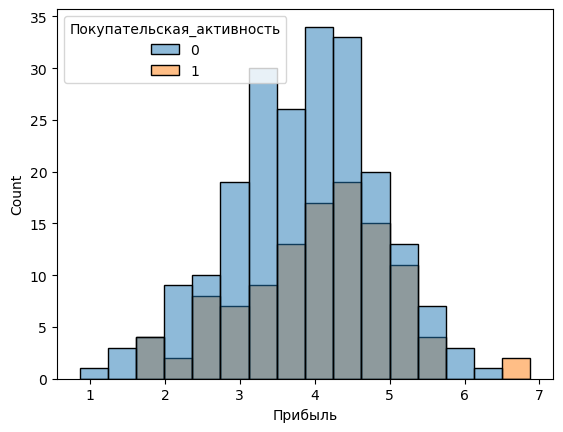

In [208]:
sns.histplot(data=df_fin, x='Прибыль',hue='Покупательская_активность');

По гистограмме видно, что покупательская активность снижается для клиентов средней и высокой прибыльности то есть тех, кто приносит основной доход. Гистрограмма обладает нормальным распределением, следовательно все значения расположены равномерно.

Добавим признак акционные покупки и посморим на его распределение.

<Axes: xlabel='Акционные_покупки', ylabel='count'>

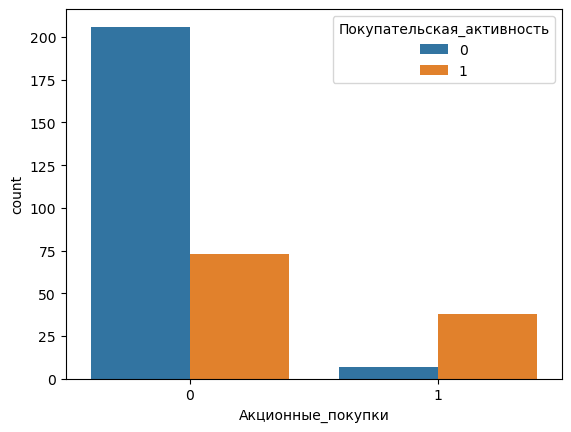

In [209]:
df_fin = df_fin.merge(df_pred['Акционные_покупки'], on = 'id', how='inner')
sns.countplot(data=df_fin, x='Акционные_покупки', hue='Покупательская_активность')

Товары по акции покупаются значительно меньше и их покупатели находятся в зоне снижения активности. Следует рассмотреть это подробнее

<Axes: xlabel='Прибыль', ylabel='Count'>

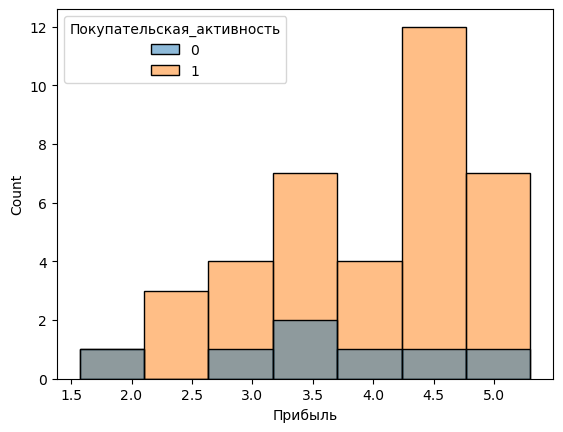

In [210]:
display(sns.histplot(df_fin.query('Акционные_покупки == 1'), x ='Прибыль', hue='Покупательская_активность'));



Посмотрим на связь акционных покупок и популярной категории у покупателя.

In [211]:
df_fin = df_fin.merge(df_pred['Популярная_категория'], on = 'id', how='inner')

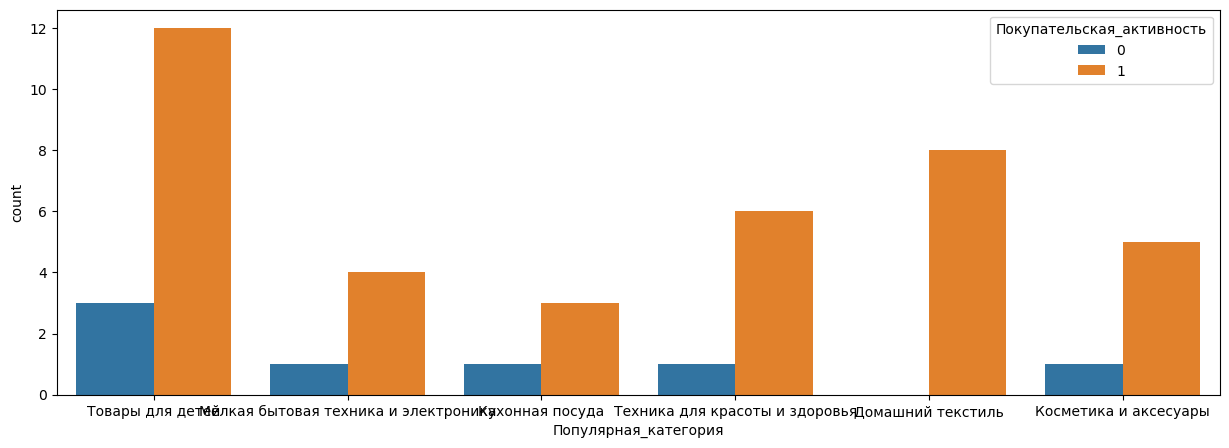

In [212]:
plt.figure(figsize=(15, 5))
sns.countplot(data = df_fin.query('Акционные_покупки == 1'), x='Популярная_категория', hue='Покупательская_активность');

У 5 категорий снижение активности приобладает

Посмотрим соотношение прибыльности категорий для покупателей участовавших в акции. 

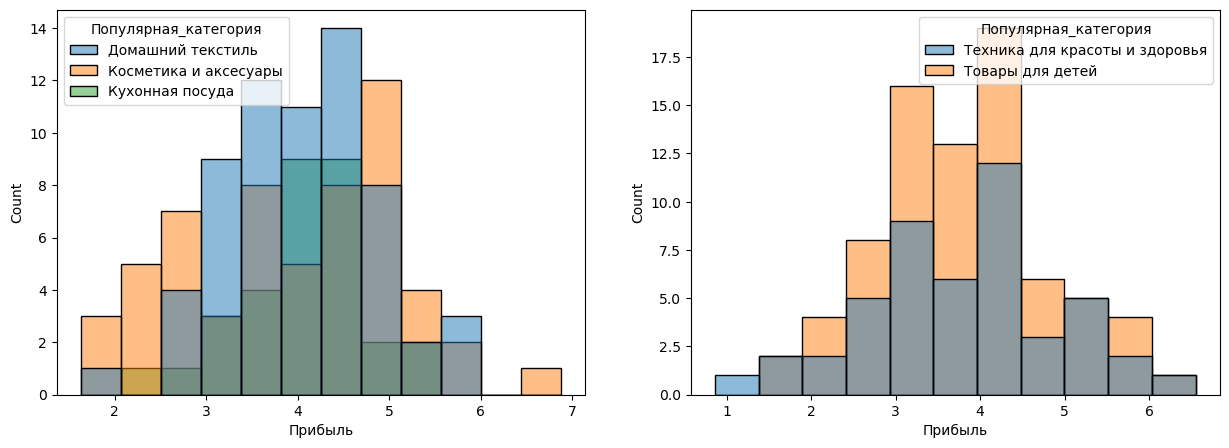

In [213]:
df_fin_unpop_1 = df_fin.query('(Популярная_категория == "Домашний текстиль")|(Популярная_категория == "Косметика и аксесуары")|(Популярная_категория == "Кухонная посуда")')
df_fin_unpop_2 = df_fin.query('(Популярная_категория == "Товары для детей")|(Популярная_категория == "Техника для красоты и здоровья")')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_fin_unpop_1, x='Прибыль',hue='Популярная_категория');

plt.subplot(1, 2, 2)
sns.histplot(df_fin_unpop_2, x='Прибыль',hue='Популярная_категория');

Данные категории имеют схожую прибыль
 
При анализе было выяснено, что наибольшей зависмостью с акционными покупками имеют признаки тек_месяц_минут и страниц_за_визит. Так 

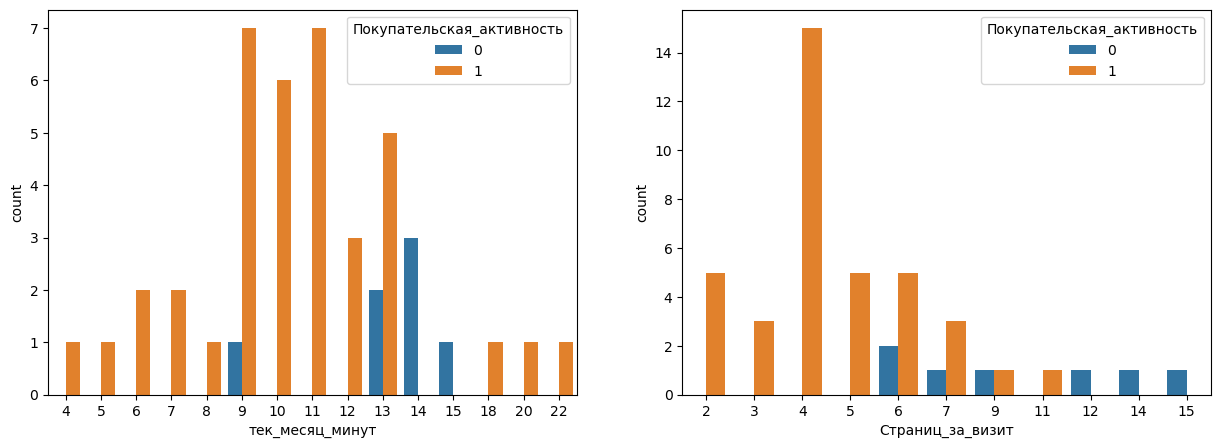

In [214]:
df_fin = df_fin.merge(df_pred[['тек_месяц_минут']], on = 'id', how='inner')
df_fin = df_fin.merge(df_pred[['Страниц_за_визит']], on = 'id', how='inner')
df_fin.head()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(data = df_fin.query('Акционные_покупки == 1'), x='тек_месяц_минут', hue='Покупательская_активность');

plt.subplot(1, 2, 2)
sns.countplot(data = df_fin.query('Акционные_покупки == 1'), x='Страниц_за_визит', hue='Покупательская_активность');

In [215]:
sum_past = df_fin[df_fin['Разница выручки пред_месяца и препред_месяца'] < 0]
print('Количество покупателей с отрицательной разницей выручки:',sum_past.shape[0])

print('Увеличение выручки, доля покупателей:',sum_past[sum_past['Разница выручки тек_месяца и пред_месяца']
                                                       > 0].shape[0]/sum_past.shape[0])

Количество покупателей с отрицательной разницей выручки: 136
Увеличение выручки, доля покупателей: 0.7058823529411765


In [216]:
s = ((df_fin['Разница выручки тек_месяца и пред_месяца'] < 0) 
     & (df_fin['Разница выручки пред_месяца и препред_месяца']<0)).sum()

print('Количество покупателей с постоянным снижением выручки в течении периода:', s)

Количество покупателей с постоянным снижением выручки в течении периода: 39


#### Вывод

Наибольшее снижение активности произошло для клиентов, покупающих по акциям в категориях:

- косметика и аксессуары
- домашний текстиль
- товары для детей 
- кухонная посуда

Категории, попадающие в зону риска, не имееют особенностей по распределению прибыли для каждой категории. Значение прибыли распределяется равномерно для всех данных в сегменте. 

При анализе сегмента выяснилось, что спонтанные покупки по акции негативно сказываются на активности в дальнейшем. Для сохранения покупательской активности стоит обратить внимание на удержание покупателей на более длительное время на сайте.

Также найдены особенности:

Есть 39 покупателей с постоянным снижением выручки в течении периода в 3 месяца.
Заметно, что было большое снижение продаж 3 месяца назад, однако, 71% от этих покупателей вернулись.

## Общий вывод

Первичный просмотр датасетов не выявил проблем. При дальнейшей обработке были испрвлены дубликаты и удалена строка с аномальным значением.

Анализ данных показал, что покупательская активность сильно зависит от того, сколько времени клиенты тратят на сайт. Нективных покупателей не оказалось.

Для числовых данных построена матрица корреляции с учетом корреляции Спирмана. Также построены еще две матрицы, учитывающие все типы данных: для данных со снижением и для данных с прежним уровнем покупательской активности. 

Выяснилось, что клиенты с более старым id имеют тенденцию к снижению активности

Было обучена модель DecisionTreeClassifier() с использованием подбора гиперпараметров в RandomizedSearchCV(). Наиболее походящяя по условиям метрика: recall. Она позволит уменьшить количество пропусков предсказанных 1.

- Показания метрики recall на валидационной выборке 0.74
- На тестовой:  0.77

При анализе веса признаков выяснилось, что наименее популярные категории товаров: косметика и аксессуары и кухонная посуда. Ошибки сервиса не снижают покупательскую активность. Возможно ошибки являются не критичными, либо быстро исправляются.

Покупатели разделены на 4 сегмента, сегмент финансового поведения дополнительно проанализирован. Для сохранения активности стоит задерживать внимание покупателей на сайте.

Были найдены особенности сегмента:
- Есть категории, имеющие почти полную вероятность снижения активности. Распределение прибыли для них не выходит за пределы нормы.
- Введение акции в прошлом месяце вернуло 71% покупателей из зоны падения выручки.
- Постоянное снижение выручки в течении 3 месяцев замечено у 39 покупателей